In [ ]:
%pylab inline

import pylab
import seaborn as sns
import numpy as np
sns.set_context("talk")

In [ ]:
from nengo.dists import CosineSimilarity
from nengolib.stats import sphere

rng = np.random.RandomState(seed=0)

def generate_vocab(size, dimension, max_similarity, num_attempts=100, rng=rng):
    sps = np.empty((size, dimension))
    for i in range(size):
        candidates = sphere.sample(num_attempts, dimension, rng=rng)
        if i == 0:
            j = 0
        else:
            sims = candidates.dot(sps[:i].T).max(axis=1)
            j = np.argmin(sims)
            if sims[j] > max_similarity:
                raise RuntimeError("Failed on iteration %d / %d with max_similarity=%s" % (
                    i, size, max_similarity))
        sps[i] = candidates[j]
    return sps

D = 50     # number of dimensions (number of hidden/observed variables)
M = 1000  # size of vocabulary (number of discrete possibilities for alpha)
sigma_z = 0.1
sigma_x = 0.5

# SS 
V = generate_vocab(M, D, CosineSimilarity(D).ppf(1 - 1. / M))  # sphere.sample(M, D, rng=rng)

def draw(N):
    alpha = rng.randint(0, M, size=N)
    Z = sigma_z * rng.randn(N, D) + V[alpha]
    X = Z * (1 + sigma_x * rng.randn(N, D))
    return alpha, Z, X

In [ ]:
if D == 2:
    cmap = sns.color_palette(None, M)
    
    with sns.axes_style('white'):
        pylab.figure()
        alpha, Z, X = draw(1000)
        c = [cmap[a] for a in alpha]
        pylab.scatter(*Z.T, c=c, s=10, marker='+')
        pylab.scatter(*X.T, c=c, s=30, marker='s')
        for a in range(M):
            pylab.scatter(*V[a], c=cmap[a], s=100, lw=2)
        pylab.axes().set_aspect('equal', 'datalim')
        r = np.max(abs(X))
        pylab.xlim(-r, r)
        pylab.ylim(-r, r)
        pylab.show()

In [3]:
K = 1000  # resolution of PDFs
R = 2     # maximum absolute value of each x_i and z_i
axis = np.linspace(-R, R, K)
       
def normal(mu, std, axis=axis):
    return np.exp(-(axis - mu)**2 / (2*std**2)) / np.sqrt(2*std**2*np.pi)

pZA = np.empty((D, K, M))  # pZA[i, j, a] = p(z_i=axis[j] | alpha=a)
for a in range(M):
    for i in range(D):
        pZA[i, :, a] = normal(V[a, i], sigma_z)

logpZA = np.log(pZA)

#SS: whats happening here? 
def pXZ(x, std_min=0.1):  # pXZ(x)[i, j] = p(x_i=x[i] | z_i=axis[j])
    return normal(
        axis[None, :],
        np.abs(axis[None, :] * sigma_x).clip(std_min),  # for numerical reasons (zero division)
        axis=x[:, None])

# Sanity checks -- if these fail we need to handle the computations specially
assert np.isfinite(pZA).all()
for a in range(M):
    assert np.isfinite(pXZ(V[a])).all()

### Stepwise Expectation Maximization
(February 14, 2016)

Stepwise EM is sensitive to the value of mini-batch size depending upon the problem at hand. Sometimes it works for a mini-batch size equal to 1, however it turns out that with this formulation, mini-batch of size > 1 is required. As the mini-batch size increases, the performance improves. However, the performance is still worse than nearest neighbour since the algorithm gets stuck in local maxima (stepwise EM is a stochastic algorithm guaranteed to converge to a local maxima which might not necessarily be the global maxima).

In this implementation of stepwise EM, thers only one batch iteration. So the number of updates is equal to the number of examples/mini-batch size (e.g., 50/10 = 5), whereas for basic EM, there are 5 batch iterations and hence number of updates is also 5. Accuracy of stepwise EM approaches that of basic EM as the mini-batch size is increased.

Reference: http://cs.stanford.edu/~pliang/papers/online-naacl2009.pdf

In [40]:
from nengo.utils.progress import ProgressTracker

def nearest_neighbour(x):
    # Find nearest neighbour after normalizing
    return np.argmax(V.dot(x / np.linalg.norm(x)))

def maximum_likelihood(x):
    L = np.zeros(M)
    for i, p in enumerate(pXZ(x)):
        L += np.log(p.dot(pZA[i]))
    return np.argmax(L)

def expectation_maximization(x, num_iter=5):
    #a = rng.randint(0, M)
    a = nearest_neighbour(x)
    _pXZ = pXZ(x)
    #print "shape: ", _pXZ.shape   (8, 1000)
    best_a = None
    best_utility = float('-inf')
    for _ in range(num_iter):
        L = np.zeros(M)
        for i, p in enumerate(_pXZ):
            pxz = p * pZA[i, :, a]
            L += (pxz / np.sum(pxz)).dot(logpZA[i])
        
        max_a = np.argmax(L)
        if L[max_a] > best_utility:
            best_a = max_a
            best_utility = L[max_a]
        
        # Keep trying new things anyways, in case we are
        # trapped in a discrete local minima
        L[a] = np.min(L)
        a = np.argmax(L)
        if a == best_a:  # considered already
            break
    return best_a



# stepwise EM without worrying about local maxima
# beta parameter:  0.5 < beta < 1. The smaller the beta, 
# the larger the updates, and the more quickly we forget 
# (decay) our old sufficient statistics. 
def stepwise_expectation_maximization(x, num_iter=1):
    #a = rng.randint(0, M)
    a = nearest_neighbour(x)
    _pXZ = pXZ(x)
    best_a = None
    best_utility = float('-inf')
    flag = 0
    
    S = np.zeros(M)   # sufficient statistics
    k = 0             # number of updates made to S so far/ minibatch index
    beta = 0.86       # can start low and increase gradually
    m = 10            # mini-batch size
    _pXZ_list = list(enumerate(_pXZ))

    for _ in range(num_iter):
        random.shuffle(_pXZ_list) 
        flag = 0
        for i, p in _pXZ_list:
            if flag%m == 0:
                L = np.zeros(M)     
            pxz = p * pZA[i, :, a]
            L += (pxz / np.sum(pxz)).dot(logpZA[i])
            flag = flag + 1
            if flag%m != 0:
                continue
        
            gamma = np.power(float(k+2), -beta)  # learning rate
            k = k + 1
            
            S = gamma*L + (1-gamma)*S
            max_a = a = np.argmax(S)
            
            #print "max a: ", max_a, i
            #print " a: ", a, i
            
    return max_a


# Storing a guess at best_alpha
# sometimes doesn't work very well since S is  
# being updated with every incoming mini-batch
# Is there a nice way to kick it out of the local
# maxima that could get us better accuracy?
def stepwise_expectation_maximization2(x, num_iter=1):
    #a = rng.randint(0, M)
    a = nearest_neighbour(x)
    _pXZ = pXZ(x)
    best_a = None
    best_utility = float('-inf')
    flag = 0
    
    S = np.zeros(M)   # sufficient statistics
    k = 0             # number of updates made to S so far/ minibatch index
    beta = 0.86       # can start low and increase gradually
    m = 10             # mini-batch size
    _pXZ_list = list(enumerate(_pXZ))

    for _ in range(num_iter):
        random.shuffle(_pXZ_list) 
        flag = 0
        for i, p in _pXZ_list:
            if flag%m == 0:
                L = np.zeros(M)     
            pxz = p * pZA[i, :, a]
            L += (pxz / np.sum(pxz)).dot(logpZA[i])
            flag = flag + 1
            if flag%m != 0:
                continue
        
            gamma = np.power(float(k+2), -beta)  # learning rate
            k = k + 1
            
            S = gamma*L + (1-gamma)*S
            max_a = a = np.argmax(S)
            
            
            if S[max_a] > best_utility:
                best_a = max_a
                best_utility = S[max_a]
                
            #print "max a: ", max_a, i
            #print "best a: ", best_a, i
            #print " a: ", a, i
                               
    return best_a


def grade_solution(f, n_trials, name=None, plot=True):
    alpha, Z, X = draw(n_trials)
    correct = 0
    dists = np.empty(n_trials)
    with ProgressTracker(1, True, "Initializing"): pass  # Hack to fix bug
    with ProgressTracker(n_trials, True, name) as progress:
        for j in range(n_trials):
            #print "X, alpha: ", X[j], alpha[j]
            a_est = f(X[j])
            if a_est == alpha[j]:
                correct += 1
            dists[j] = np.dot(V[a_est], V[alpha[j]])
            progress.step()
    acc = correct / float(n_trials)
    if plot:
        pylab.figure()
        pylab.title("%s (Accuracy = %.3f)" % (name, acc))
        sns.kdeplot(dists)
        #pylab.hist(dists, bins=M)
        pylab.xlabel(r"$V[\hat{\alpha}] \cdot V[\alpha]$")
        sns.despine(offset=10)
        pylab.show()
    return acc

Initializing finished in 0:00:01.                                               
Nearest Neighbour finished in 0:00:01.                                          


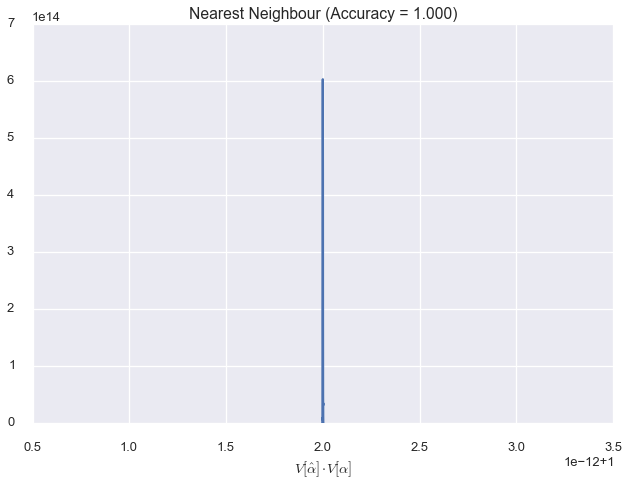

1.0

In [5]:
grade_solution(nearest_neighbour, n_trials=2000, name="Nearest Neighbour")

Initializing finished in 0:00:01.                                               
Maximum Likelihood Estimation finished in 0:01:00.                              


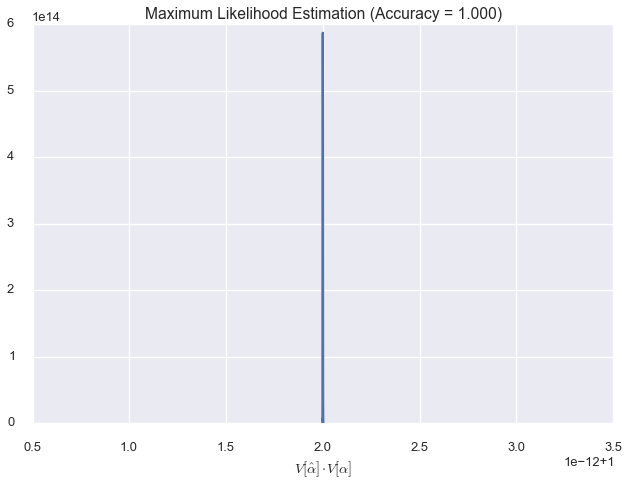

1.0

In [6]:
grade_solution(maximum_likelihood, n_trials=2000, name="Maximum Likelihood Estimation")

Initializing finished in 0:00:01.                                               
Expectation Maximization finished in 0:02:12.                                   


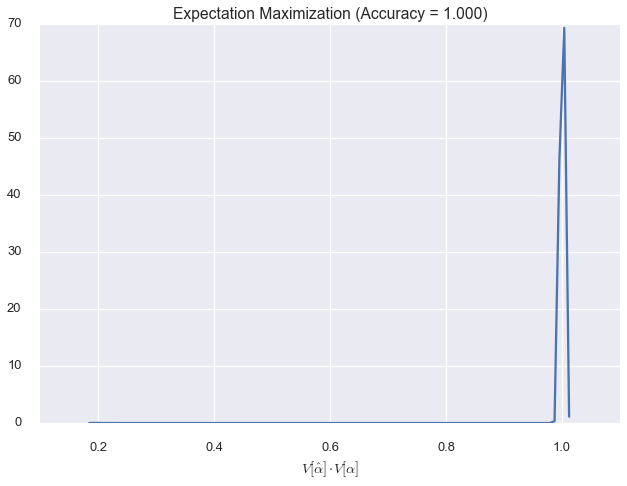

0.9995

In [36]:
grade_solution(expectation_maximization, n_trials=2000, name="Expectation Maximization")

Initializing finished in 0:00:01.                                               
Stepwise Expectation Maximization finished in 0:01:16.                          


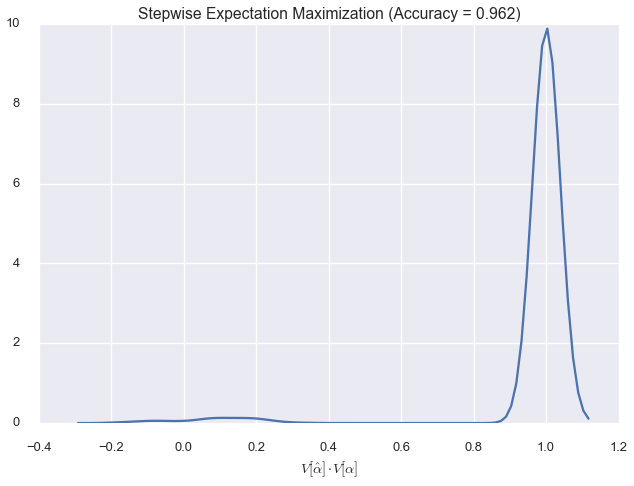

0.9615

In [41]:
grade_solution(stepwise_expectation_maximization, n_trials=2000, name="Stepwise Expectation Maximization")

Initializing finished in 0:00:01.                                               
Stepwise Expectation Maximization finished in 0:03:33.                          


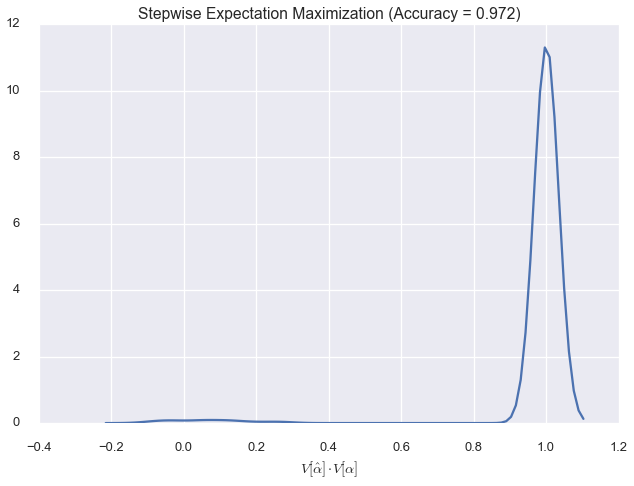

0.9715

In [35]:
grade_solution(stepwise_expectation_maximization2, n_trials=2000, name="Stepwise Expectation Maximization")

In [ ]:
# Debugging
alpha, _, X = draw(1)
ideal = alpha[0]
x = X[0]

print maximum_likelihood(x) == ideal
print nearest_neighbour(x) == ideal

In [ ]:
# Debugging cont'd...
num_iter = 1
# print expectation_maximization(x, num_iter)

a = nearest_neighbour(x)
#a = ideal

_pXZ = pXZ(x)
for _ in range(num_iter):
    L = np.zeros(M)
    for i, p in enumerate(_pXZ):
        pxz = p * pZA[i, :, a]
        L += (pxz / np.sum(pxz)).dot(logpZA[i])
    #L[a] = np.min(L)
    a = np.argmax(L)

    dists = V.dot(V[ideal])
    order = np.argsort(dists)
    pylab.figure()
    pylab.scatter(dists[order], L[order])
    pylab.show()
    print ideal, a, np.max(L)